In [17]:
pip install plotting 

   ---------------------------------------- 0.0/11.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.6 MB ? eta -:--:--
   -- ------------------------------------- 0.8/11.6 MB 4.2 MB/s eta 0:00:03
   ------ --------------------------------- 1.8/11.6 MB 5.0 MB/s eta 0:00:02
   ------------ --------------------------- 3.7/11.6 MB 6.2 MB/s eta 0:00:02
   ------------------ --------------------- 5.5/11.6 MB 6.7 MB/s eta 0:00:01
   ------------------------ --------------- 7.1/11.6 MB 7.0 MB/s eta 0:00:01
   ----------------------------- ---------- 8.7/11.6 MB 7.2 MB/s eta 0:00:01
   ------------------------------------ --- 10.5/11.6 MB 7.2 MB/s eta 0:00:01
   ---------------------------------------  11.5/11.6 MB 7.3 MB/s eta 0:00:01
   ---------------------------------------- 11.6/11.6 MB 6.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [23]:
pip show plotting

Name: plotting
Version: 0.0.7
Summary: UNKNOWN
Home-page: UNKNOWN
Author: Michael Rossol
Author-email: mrossol@gmail.com
License: BSD license
Location: c:\users\77003\anaconda3\envs\ven_shrudenger\lib\site-packages
Requires: matplotlib, pandas, seaborn
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [32]:
import sys
import os
sys.path.insert(0, '../../Utilities/')

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.io

In [77]:
# Часть кода которая выполняет AC
class PhysicsInformedNN:
    def __init__(self, x0, u0, x1, layers, dt, lb, ub, q):
        self.x0 = x0
        self.u0 = u0
        self.x1 = x1
        self.layers = layers
        self.dt = dt
        self.lb = lb
        self.ub = ub
        self.q = q
        # Initialize neural networks
        self.net_U0 = self.build_net()
        self.net_U1 = self.build_net()
        # Initialize IRK weights (you need to define the logic for weights)
        self.IRK_weights = self.initialize_IRK_weights()
        # Initialize optimizer
        self.optimizer = tf.keras.optimizers.Adam()

    def build_net(self):
        """Build the neural network."""
        model = tf.keras.Sequential()
        for layer_size in self.layers:
            model.add(tf.keras.layers.Dense(layer_size, activation='tanh'))
        return model

    def initialize_IRK_weights(self):
        """Initialize IRK weights (This needs to be customized)."""
        return np.array([[1]])  # Example value

    def net_U1(self, x):
        return self.net_U1(x)  # Return the output of the neural network net_U1 for input x

    def train(self, nIter):
        for it in range(nIter):
            with tf.GradientTape() as tape:
                # Compute predictions for the initial condition x0 and the boundary condition x1
                U0_pred = self.net_U0(self.x0)
                U1_pred = self.net_U1(self.x1)
                
                # Calculate the loss
                loss = tf.reduce_sum(tf.square(self.u0 - U0_pred)) + \
                       tf.reduce_sum(tf.square(U1_pred[0, :] - U1_pred[1, :]))
            
            # Compute gradients of the loss with respect to the trainable variables of both networks
            grads = tape.gradient(loss, self.net_U0.trainable_variables + self.net_U1.trainable_variables)
            
            # Apply gradients to update the weights of the networks
            self.optimizer.apply_gradients(zip(grads, self.net_U0.trainable_variables + self.net_U1.trainable_variables))
    
            # Optional: Print the loss every few iterations
            if it % 10 ** 3 == 0:
                print(f"Iteration {it}, Loss: {loss.numpy()}")
                
    def fwd_gradients_0(self, U, x):
        """Compute forward gradients of U with respect to x."""
        with tf.GradientTape() as tape:
            tape.watch(x)
            g = U
        grad = tape.gradient(g, x)
        if grad is None:
            raise ValueError("Gradient calculation failed, grad is None.")
        return grad

    def net_U0(self, x):
        """Compute the U0 prediction."""
        U1 = self.net_U1(x)
        U = U1[:, :-1]  # Remove the last dimension if it's not needed
        if U is None:
            raise ValueError("Output U is None, check the neural network output.")
        U_x = self.fwd_gradients_0(U, x)
        U_xx = self.fwd_gradients_0(U_x, x)
        F = 5.0 * U - 5.0 * U**3 + 0.0001 * U_xx
        U0 = U1 - self.dt * tf.matmul(F, self.IRK_weights.T)
        return U0

    def predict(self, x_star):
        """Predict using the trained model."""
        return self.net_U0(x_star)

In [78]:
# Скачивания жанных и прописания начальных паараметров

print(os.getcwd())

# Load the data from the .mat file
data = scipy.io.loadmat('AC.mat')

# Extract the necessary variables
t = data['tt'].flatten()[:, None]  # Time values
x = data['x'].flatten()[:, None]   # Spatial values
Exact = np.real(data['uu']).T      # Real part of 'uu', transposed for correct shape

# Select indices for initialization
idx_t0 = 20
idx_t1 = 180

# Примерно при 5000 - 10000 выходит от Loss: 0.2 ~ 0.11
# При 100000 выходит Loss: 0.04
iterations = 10 ** 5 

# Initialize data
N = 100  # Number of spatial points to select
idx_x = np.random.choice(Exact.shape[1], N, replace=False)  # Randomly select N points

x0 = x[idx_x, :]  # Spatial points at t0
u0 = Exact[idx_t0:idx_t0+1, idx_x].T  # Corresponding initial condition data

# Boundary conditions
lb = x.min()  # Lower boundary (min value of x)
ub = x.max()  # Upper boundary (max value of x)


C:\Users\77003\JupyterLab\PINN_course\HW_2


In [79]:
# Make predictions
x_star = x  # Assuming we want predictions over all x points
U1_pred = model.predict(x_star)  # Make predictions using the trained model# Create the model
model = PhysicsInformedNN(x0, u0, x1, layers, dt, lb, ub, q)

# Train the model
model.train(iterations)  # Training for 100 iterations

# Make predictions after training
x_star = x  # Assuming we want predictions over all x points
U1_pred = model.predict(x_star)  # Make predictions using the trained model


Iteration 0, Loss: 380.7487487792969
Iteration 1000, Loss: 92.67313385009766
Iteration 2000, Loss: 27.189899444580078
Iteration 3000, Loss: 16.938087463378906
Iteration 4000, Loss: 0.4322851896286011
Iteration 5000, Loss: 0.1335846185684204
Iteration 6000, Loss: 0.10962999612092972
Iteration 7000, Loss: 0.08916563540697098
Iteration 8000, Loss: 0.07013754546642303
Iteration 9000, Loss: 0.05822049826383591
Iteration 10000, Loss: 0.05113069713115692
Iteration 11000, Loss: 0.04594104737043381
Iteration 12000, Loss: 0.0423838272690773
Iteration 13000, Loss: 0.039775703102350235
Iteration 14000, Loss: 0.039765745401382446
Iteration 15000, Loss: 0.036111101508140564
Iteration 16000, Loss: 0.03481251373887062
Iteration 17000, Loss: 0.033729907125234604
Iteration 18000, Loss: 0.03282435983419418
Iteration 19000, Loss: 0.03482212871313095
Iteration 20000, Loss: 0.03134523332118988
Iteration 21000, Loss: 0.03073699213564396
Iteration 22000, Loss: 0.030181530863046646
Iteration 23000, Loss: 0.029

C:\Users\77003\AppData\Local\Temp\ipykernel_4836\1149467156.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax1.set_title('$t = %.2f$' % (t[idx_t0]), fontsize=10)
C:\Users\77003\AppData\Local\Temp\ipykernel_4836\1149467156.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax2.set_title('$t = %.2f$' % (t[idx_t1]), fontsize=10)


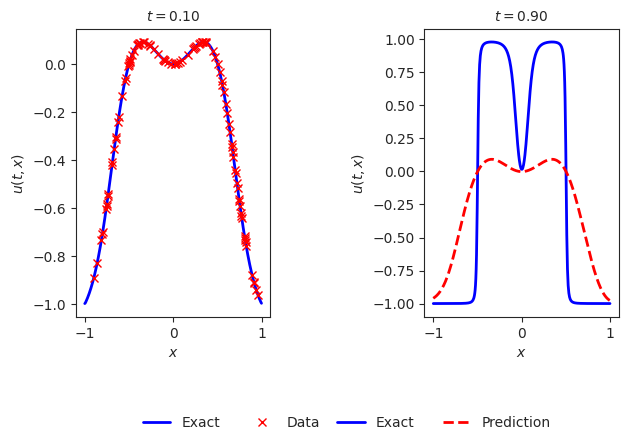

In [80]:
# Plotting the results
import matplotlib.gridspec as gridspec

# Define the grid for subplots
gs1 = gridspec.GridSpec(1, 2)

# First plot at time t0
ax1 = plt.subplot(gs1[0, 0])
ax1.plot(x, Exact[idx_t0, :], 'b-', linewidth=2, label='Exact')  # Exact solution at t0
ax1.plot(x0, u0, 'rx', linewidth=2, label='Data')  # Initial condition
ax1.set_xlabel('$x$')
ax1.set_ylabel('$u(t, x)$')
ax1.set_title('$t = %.2f$' % (t[idx_t0]), fontsize=10)
ax1.set_xlim([lb - 0.1, ub + 0.1])
ax1.legend(loc='upper center', bbox_to_anchor=(0.8, -0.3), ncol=2, frameon=False)

# Second plot at time t1
ax2 = plt.subplot(gs1[0, 1])
ax2.plot(x, Exact[idx_t1, :], 'b-', linewidth=2, label='Exact')  # Exact solution at t1
ax2.plot(x_star, U1_pred.numpy()[:, 0], 'r--', linewidth=2, label='Prediction')  # Predicted solution
ax2.set_xlabel('$x$')
ax2.set_ylabel('$u(t, x)$')
ax2.set_title('$t = %.2f$' % (t[idx_t1]), fontsize=10)
ax2.set_xlim([lb - 0.1, ub + 0.1])
ax2.legend(loc='upper center', bbox_to_anchor=(0.1, -0.3), ncol=2, frameon=False)

# Display the plots
plt.tight_layout()
plt.show()